# Urban Agriculture & Toxic Release Activities in LA County

This notebook includes (1) data cleaning for a datasets on urban agriculture in LA County and toxic release activities in California, (2) the joining of these datasets to municipal boundaries for cities in LA County, and (3) maps depicting distributions of both across LA County municipalities that were subsequently produced using the cleaned/subsetted/geolocated data.

While General Plans were collected for five CA Counties -- LA, Ventura, Sonoma, Mendocino, and Lake -- most of the analysis will focus on LA County for this project.

In [1]:
# libraries
import pandas as pd
import geopandas as gpd
import numpy as np

import contextily as ctx
import matplotlib.pyplot as plt
import folium

In [58]:
# loading files

# municipalities list
munis = pd.read_csv('C:/Users/melod/Documents/data science/Food-Systems-Policy-Research/Food Systems and General Plans/data/Municipalities List.csv')

# municipal boundaries for LA County cities
LACcitieslines  = gpd.read_file('C:/Users/melod/Documents/data science/Food-Systems-Policy-Research/Food Systems and General Plans/data/City_Boundaries.geojson')

# toxic release data for California
toxrel = pd.read_csv('C:/Users/melod/Documents/data science/Food-Systems-Policy-Research/Food Systems and General Plans/data/2021_ca.csv')

# LA County urban agriculture sites
UALAC = pd.read_excel('C:/Users/melod/Documents/data science/Food-Systems-Policy-Research/Food Systems and General Plans/data/Cultivate LA sites (as of 4.1.2017).xlsx')

### Municipalities Data

The geodata files for the boundaries for both incorporated and unincorporated places in LA County were sourced from the [Los Angeles County Open Data](https://data.lacounty.gov/datasets/a76e9954365d4608aa8ae81959f402f7_19/about) website. While there are 88 incorporated cities in Los Angeles County, many places (almost 200) are located in unincorporated areas of the County. These areas are governed by the County's general plan. 

I created the "munis" list and saved it as a .csv file. The five counties of interest for this project in the long term are represented on this list and it will be used to add County and CA region identifiers to the cities in other dataframes and geodataframes developed in this and other notebooks.

In [3]:
LACcitieslines.head(2)

,OBJECTID,CITY_NAME,CITY_LABEL,ABBR,OF_AREA_SM,CITY_TYPE,FEAT_TYPE,COLOR_EGIS,URL,PHONE,last_edited_date,ShapeSTArea,ShapeSTLength,geometry
0,366,Long Beach,Long Beach,LB,50.309,City,Breakwater,"Purple - RGB 185,185,250",www.longbeach.gov,5625706555,2022-07-20 00:08:28+00:00,1.097324e+05,5448.776853,"POLYGON ((-118.11850 33.74278, -118.11855 33.7..."
1,367,Redondo Beach,Redondo Beach,RBCH,6.349,City,Water,"Pink - RGB 255,190,232",www.redondo.org,3103721171,2022-07-20 00:08:28+00:00,4.883225e+06,21127.481570,"POLYGON ((-118.39235 33.84190, -118.39238 33.8..."


In [60]:
LACcitieslines.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   OBJECTID          347 non-null    int64              
 1   CITY_NAME         347 non-null    object             
 2   CITY_LABEL        347 non-null    object             
 3   ABBR              347 non-null    object             
 4   OF_AREA_SM        347 non-null    float64            
 5   CITY_TYPE         347 non-null    object             
 6   FEAT_TYPE         347 non-null    object             
 7   COLOR_EGIS        347 non-null    object             
 8   URL               347 non-null    object             
 9   PHONE             347 non-null    object             
 10  last_edited_date  347 non-null    datetime64[ns, UTC]
 11  ShapeSTArea       347 non-null    float64            
 12  ShapeSTLength     347 non-null    float64            
 1

In [62]:
# confirming that there are 88 munis + unincorporated places in this geojson file
LACcitieslines['CITY_NAME'].value_counts()

Unincorporated      190
Los Angeles          33
Long Beach           21
Redondo Beach        10
Santa Clarita         4
                   ... 
La Verne              1
Irwindale             1
Norwalk               1
Agoura Hills          1
Hawaiian Gardens      1
Name: CITY_NAME, Length: 89, dtype: int64

### Toxic Release Data for California (cleaning)

This dataset was downloaded from [California Toxics Release Inventory (TRI) Program](https://www.epa.gov/toxics-release-inventory-tri-program/tri-basic-data-files-calendar-years-1987-present), which contains the facility names, their geocoded locations, and on and off-site discharge amounts produced by facilities for facilities located in California. The website includes data collected from 1987 to 2021. I am using the 2021 data.

I need to subset data from my five counties of interest from this dataset, though I will be looking exclusively/preliminarily at Los Angeles County only for the purposes of this project.

In [9]:
# inspecting
toxrel['7. COUNTY'].value_counts()

LOS ANGELES        1330
SAN BERNARDINO      256
CONTRA COSTA        254
ORANGE              208
KERN                179
SAN DIEGO           159
ALAMEDA             114
SANTA CLARA          97
RIVERSIDE            95
SAN JOAQUIN          78
STANISLAUS           71
SOLANO               67
TULARE               63
SACRAMENTO           61
VENTURA              57
FRESNO               54
KINGS                49
SAN LUIS OBISPO      39
SONOMA               29
MERCED               28
MADERA               20
SHASTA               19
PLACER               19
YOLO                 18
SAN MATEO            16
SANTA BARBARA        16
IMPERIAL             13
LASSEN               12
SAN BENITO            9
SAN FRANCISCO         9
MONTEREY              8
HUMBOLDT              6
SISKIYOU              5
PLUMAS                5
AMADOR                4
YUBA                  4
NAPA                  3
GLENN                 3
INYO                  3
NEVADA                2
MENDOCINO             2
COLUSA          

In [11]:
# subsetting toxrelease data for counties of interest
toxrelLAC = toxrel[toxrel['7. COUNTY'] == 'LOS ANGELES']
toxrelVEN = toxrel[toxrel['7. COUNTY'] == 'VENTURA']
toxrelSON = toxrel[toxrel['7. COUNTY'] == 'SONOMA']
toxrelMEN= toxrel[toxrel['7. COUNTY'] == 'MENDOCINO']
toxrelLAK= toxrel[toxrel['7. COUNTY'] == 'LAKE']

# looking at LAC
toxrelLAC.tail(3)

,1. YEAR,2. TRIFD,3. FRS ID,4. FACILITY NAME,5. STREET ADDRESS,6. CITY,7. COUNTY,8. ST,9. ZIP,10. BIA,...,110. 8.2 - ENERGY RECOVER ON,111. 8.3 - ENERGY RECOVER OF,112. 8.4 - RECYCLING ON SITE,113. 8.5 - RECYCLING OFF SIT,114. 8.6 - TREATMENT ON SITE,115. 8.7 - TREATMENT OFF SITE,116. PRODUCTION WSTE (8.1-8.7),117. 8.8 - ONE-TIME RELEASE,118. PROD_RATIO_OR_ ACTIVITY,119. 8.9 - PRODUCTION RATIO
3483,2021,90245CHVRN324WE,110002899908,CHEVRON PRODUCTS CO. DIV OF CHEVRON USA INC.,324 W EL SEGUNDO BLVD,EL SEGUNDO,LOS ANGELES,CA,90245,NaN,...,0.0,0.0,0.0,0.0,120000.0,0.0,124800.0,NaN,PRODUCTION,1.33
3487,2021,90749RCPRD1801E,110017428988,TESORO LOS ANGELES REFINERY-CARSON OPERATIONS,24696 S WILMINGTON AVE,CARSON,LOS ANGELES,CA,90745,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,398.0,NaN,PRODUCTION,1.20
3488,2021,90749RCPRD1801E,110017428988,TESORO LOS ANGELES REFINERY-CARSON OPERATIONS,24696 S WILMINGTON AVE,CARSON,LOS ANGELES,CA,90745,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,19.0,NaN,PRODUCTION,1.45


In [12]:
# subset toxrelLAC
toxrelLAC = toxrelLAC[['2. TRIFD', '4. FACILITY NAME', '5. STREET ADDRESS','6. CITY', '7. COUNTY', '10. BIA', 
                       '11. TRIBE', '12. LATITUDE',
                       '13. LONGITUDE', '14. HORIZONTAL DATUM', '19. INDUSTRY SECTOR CODE', '20. INDUSTRY SECTOR',
                       '27. PRIMARY NAICS', '43. CARCINOGEN', '47. UNIT OF MEASURE', '50. 5.3 - WATER', 
                       '51. 5.4 - UNDERGROUND', '52. 5.4.1 - UNDERGROUND CL I', 
                       '53. 5.4.2 - UNDERGROUND C II-V', '54. 5.5.1 - LANDFILLS', 
                       '55. 5.5.1A - RCRA C LANDFILL', '56. 5.5.1B - OTHER LANDFILLS', '57. 5.5.2 - LAND TREATMENT',
                       '58. 5.5.3 - SURFACE IMPNDMNT','59. 5.5.3A - RCRA SURFACE IM', '60. 5.5.3B - OTHER SURFACE I', 
                       '61. 5.5.4 - OTHER DISPOSAL', '62. ON-SITE RELEASE TOTAL', '85. OFF-SITE RELEASE TOTAL',
                       '91. OFF-SITE RECYCLED TOTAL', '101. OFF-SITE TREATED TOTAL', 
                       '116. PRODUCTION WSTE (8.1-8.7)', '117. 8.8 - ONE-TIME RELEASE']]
toxrelLAC.tail(3)

,2. TRIFD,4. FACILITY NAME,5. STREET ADDRESS,6. CITY,7. COUNTY,10. BIA,11. TRIBE,12. LATITUDE,13. LONGITUDE,14. HORIZONTAL DATUM,...,58. 5.5.3 - SURFACE IMPNDMNT,59. 5.5.3A - RCRA SURFACE IM,60. 5.5.3B - OTHER SURFACE I,61. 5.5.4 - OTHER DISPOSAL,62. ON-SITE RELEASE TOTAL,85. OFF-SITE RELEASE TOTAL,91. OFF-SITE RECYCLED TOTAL,101. OFF-SITE TREATED TOTAL,116. PRODUCTION WSTE (8.1-8.7),117. 8.8 - ONE-TIME RELEASE
3483,90245CHVRN324WE,CHEVRON PRODUCTS CO. DIV OF CHEVRON USA INC.,324 W EL SEGUNDO BLVD,EL SEGUNDO,LOS ANGELES,NaN,NaN,33.9082,-118.4085,NAD83,...,0.0,0.0,0.0,0.0,4800.0,0.0,0.0,0.0,124800.0,NaN
3487,90749RCPRD1801E,TESORO LOS ANGELES REFINERY-CARSON OPERATIONS,24696 S WILMINGTON AVE,CARSON,LOS ANGELES,NaN,NaN,33.8099,-118.2383,NAD83,...,0.0,0.0,0.0,0.0,0.0,400.0,0.0,0.0,398.0,NaN
3488,90749RCPRD1801E,TESORO LOS ANGELES REFINERY-CARSON OPERATIONS,24696 S WILMINGTON AVE,CARSON,LOS ANGELES,NaN,NaN,33.8099,-118.2383,NAD83,...,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,19.0,NaN


In [13]:
# rename geometry columns
toxrelLAC.rename(columns ={ '12. LATITUDE': 'LAT', '13. LONGITUDE': 'LON'}, inplace=True)

# convert to gdf
toxrelLACg = gpd.GeoDataFrame(toxrelLAC, geometry=gpd.points_from_xy(toxrelLAC.LON, toxrelLAC.LAT, 
                                          crs='EPSG:4326'))
toxrelLACg.tail(3)

,2. TRIFD,4. FACILITY NAME,5. STREET ADDRESS,6. CITY,7. COUNTY,10. BIA,11. TRIBE,LAT,LON,14. HORIZONTAL DATUM,...,59. 5.5.3A - RCRA SURFACE IM,60. 5.5.3B - OTHER SURFACE I,61. 5.5.4 - OTHER DISPOSAL,62. ON-SITE RELEASE TOTAL,85. OFF-SITE RELEASE TOTAL,91. OFF-SITE RECYCLED TOTAL,101. OFF-SITE TREATED TOTAL,116. PRODUCTION WSTE (8.1-8.7),117. 8.8 - ONE-TIME RELEASE,geometry
3483,90245CHVRN324WE,CHEVRON PRODUCTS CO. DIV OF CHEVRON USA INC.,324 W EL SEGUNDO BLVD,EL SEGUNDO,LOS ANGELES,NaN,NaN,33.9082,-118.4085,NAD83,...,0.0,0.0,0.0,4800.0,0.0,0.0,0.0,124800.0,NaN,POINT (-118.40850 33.90820)
3487,90749RCPRD1801E,TESORO LOS ANGELES REFINERY-CARSON OPERATIONS,24696 S WILMINGTON AVE,CARSON,LOS ANGELES,NaN,NaN,33.8099,-118.2383,NAD83,...,0.0,0.0,0.0,0.0,400.0,0.0,0.0,398.0,NaN,POINT (-118.23830 33.80990)
3488,90749RCPRD1801E,TESORO LOS ANGELES REFINERY-CARSON OPERATIONS,24696 S WILMINGTON AVE,CARSON,LOS ANGELES,NaN,NaN,33.8099,-118.2383,NAD83,...,0.0,0.0,0.0,19.0,0.0,0.0,0.0,19.0,NaN,POINT (-118.23830 33.80990)


### Urban Agriculture Sites in Los Angeles County (cleaning)

This dataset was shared by University of California Cooperative Extension (UC ANR) and contains over 1,000 urban agriculture sites in Los Angeles County, grouped by site type (schools, nurseries, etc.). It was originally developed by a team of UCLA MURP students in 2013 and was maintained by UC ANR up until 2017. It needs to be cleaned: some locations need to be geocoded, city names need to be correctly formatted, etc. 

For the purposes of this project, I will not be doing the extensive fact-checking to ascertain whether the municipality names associated with specific sites necessary to get the most accurate counts of the number of sites in each of the 88 recognize municipalities in the County.

In [14]:
# convert to gdf
UALACg = gpd.GeoDataFrame(UALAC, geometry=gpd.points_from_xy(UALAC.lng, UALAC.lat, 
                                          crs='EPSG:4326'))
UALACg.tail(3)

,objectid,name,address,lng,lat,type_,subtype_,source,verified,exisitng,contact,website,comment_,city,state,zip,geometry
1137,2342,"Uncommon Good, Site #16",333 North College Way,0.0,0.0,Farm,NaN,NaN,NaN,NaN,Nancy Mintie,www.uncommongood.org,NaN,Claremont,CA,91711-4429,POINT (0.00000 0.00000)
1138,3527,John R. Wooden High School,18741 Elkwood Street,0.0,0.0,School Garden,High,NaN,Verified,New Site,Karen Snook,kindredspiritscarefarm.org,Kindred Spirits Care Farm partners with John R...,Reseda,CA,91335,POINT (0.00000 0.00000)
1139,3927,GrowGood Farm,5600 MANSFIELD WAY,0.0,0.0,Farm,NaN,NaN,Verified,New Site,(323) 645-0215,https://www.grow-good.org/,NaN,Bell,California,90201,POINT (0.00000 0.00000)


In [15]:
# for now, until I can geocode locations w/o coordinates, dropping locations w/o coordinates (25 locations)
UALACg2 = UALACg[UALACg.lng != 0.0]
print(UALACg.shape)
print(UALACg2.shape)

(1140, 17)
(1015, 17)


Aggregating counts of (1) urban agriculture sites and (2) toxic release facilities for in each municipality for choropleth layer on a map.

In [16]:
# aggregating urban ag sites in LAC

# renaming columns 
UALACg2.rename(columns = {'city': 'City', 'name': 'UA Sites'}, inplace = True)

# adjusting letter case of cities in city column
UALACg2['City'] = UALACg2['City'].str.title()

UAsites = UALACg2.groupby('City')['UA Sites'].count()
UAsites

C:\Users\melod\AppData\Local\Temp\ipykernel_11252\1142825573.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UALACg2.rename(columns = {'city': 'City', 'name': 'UA Sites'}, inplace = True)
C:\Users\melod\Programs\envs\uds\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


City
Acton                5
Agoura Hills         3
Alhambra             7
Altadena             9
Arcadia              5
                    ..
Westlake Village     1
Whittier            12
Willowbrook          1
Wilmington           3
Woodland Hills       6
Name: UA Sites, Length: 150, dtype: int64

In [17]:
# aggregating toxic release facilities in LAC

# renaming columns
toxrelLACg.rename(columns = {'6. CITY': 'City', '4. FACILITY NAME': 'Facilities',
                            '62. ON-SITE RELEASE TOTAL': 'Release Total'}, inplace = True)

# adjusting letter case of cities in city column
toxrelLACg['City'] = toxrelLACg['City'].str.title()

# aggregating facility counts by city
toxrelsites = toxrelLACg.groupby('City')['Facilities'].count()
toxrelsites

City
Arcadia             6
Arleta              5
Artesia             3
Avalon              5
Azusa              30
                 ... 
Walnut              1
West Covina         1
West Hollywood      1
Whittier           10
Wilmington        123
Name: Facilities, Length: 67, dtype: int64

In [18]:
# aggregating toxic release discharge totals in LAC by city
discharge = toxrelLACg.groupby('City')['Release Total'].sum()
discharge

City
Arcadia                0.000000
Arleta                13.500000
Artesia                0.100000
Avalon              2631.000000
Azusa               5938.000000
                      ...      
Walnut                 0.000000
West Covina            0.590000
West Hollywood         0.000000
Whittier              79.000000
Wilmington        405984.135041
Name: Release Total, Length: 67, dtype: float64

In [64]:
# renaming city column in LAC city boundaries gdf
LACcitieslines.rename(columns = {'CITY_NAME': 'City'}, inplace = True) 

# resetting index for munis LAC muni boundaries gdf
LACcitieslines.set_index('City', inplace = True)

In [65]:
# joining counts of toxic release sites to muni gdf
LACfinal = LACcitieslines.join(toxrelsites)

# replacing NaN values
LACfinal['Facilities'].replace(np.nan, 0, inplace = True)
print(LACfinal['Facilities'].isna().sum())

0


In [66]:
# joining discharge totals to muni gdf
LACfinal = LACfinal.join(discharge)

# replacing NaN values
LACfinal['Release Total'].replace(np.nan, 0, inplace = True)
print(LACfinal['Release Total'].isna().sum())

0


In [67]:
# joining counts of UA sites to muni gdf
LACfinal = LACfinal.join(UAsites)

# replacing NaN values
LACfinal['UA Sites'].replace(np.nan, 0, inplace = True)
print(LACfinal['UA Sites'].isna().sum())

0


In [68]:
# renaming city column in muni list
munis.rename(columns = {'City/Municipality': 'City'}, inplace = True)

In [69]:
# setting index for munis list
munis.set_index('City', inplace = True)

In [70]:
# joining munis list to dataframe
LACfinal = LACfinal.join(munis)

In [71]:
LACfinal.head(5)

,OBJECTID,CITY_LABEL,ABBR,OF_AREA_SM,CITY_TYPE,FEAT_TYPE,COLOR_EGIS,URL,PHONE,last_edited_date,ShapeSTArea,ShapeSTLength,geometry,Facilities,Release Total,UA Sites,County,Region
City,,,,,,,,,,,,,,,,,,
Agoura Hills,548,Agoura Hills,AGH,8.054,City,Land,"Pink - RGB 255,190,232",www.agourahillscity.org,8185977300,2022-07-20 00:08:28+00:00,2.179489e+08,80384.844465,"POLYGON ((-118.72864 34.16793, -118.73666 34.1...",0.0,0.0,3.0,Los Angeles,Southern California
Alhambra,634,Alhambra,ALH,7.626,City,Land,"Pink - RGB 255,190,232",www.cityofalhambra.org,6265705007,2022-07-20 00:08:28+00:00,2.127651e+08,69047.146627,"POLYGON ((-118.12191 34.10503, -118.12204 34.1...",0.0,0.0,7.0,Los Angeles,Southern California
Arcadia,646,Arcadia,ARC,11.368,City,Land,"Purple - RGB 185,185,250",www.arcadiaca.gov,6265745400,2022-07-20 00:24:20+00:00,3.096861e+08,132160.448944,"POLYGON ((-118.01824 34.17572, -118.01637 34.1...",6.0,0.0,5.0,Los Angeles,Southern California
Artesia,622,Artesia,ART,1.614,City,Land,"Green - RGB 203,255,112",www.cityofartesia.us,5628656262,2022-07-20 00:08:28+00:00,4.520367e+07,40936.713195,"POLYGON ((-118.07950 33.87674, -118.07946 33.8...",3.0,0.1,0.0,Los Angeles,Southern California
Avalon,493,Avalon,AVLN,2.920,City,Land,"Orange - RGB 230,190,112",www.cityofavalon.com,3105100220,2022-07-20 00:08:28+00:00,8.033933e+07,57467.575832,"POLYGON ((-118.30821 33.33096, -118.30822 33.3...",5.0,2631.0,1.0,Los Angeles,Southern California


In [72]:
# keeping only columns of interest in muni dataframe
LACfinal = LACfinal[['geometry', 'Facilities', 'Release Total', 'UA Sites', 'County', 'Region']]
LACfinal

,geometry,Facilities,Release Total,UA Sites,County,Region
City,,,,,,
Agoura Hills,"POLYGON ((-118.72864 34.16793, -118.73666 34.1...",0.0,0.00,3.0,Los Angeles,Southern California
Alhambra,"POLYGON ((-118.12191 34.10503, -118.12204 34.1...",0.0,0.00,7.0,Los Angeles,Southern California
Arcadia,"POLYGON ((-118.01824 34.17572, -118.01637 34.1...",6.0,0.00,5.0,Los Angeles,Southern California
Artesia,"POLYGON ((-118.07950 33.87674, -118.07946 33.8...",3.0,0.10,0.0,Los Angeles,Southern California
Avalon,"POLYGON ((-118.30821 33.33096, -118.30822 33.3...",5.0,2631.00,1.0,Los Angeles,Southern California
...,...,...,...,...,...,...
Walnut,"POLYGON ((-117.82654 34.04153, -117.82818 34.0...",1.0,0.00,4.0,Los Angeles,Southern California
West Covina,"POLYGON ((-117.86135 34.06647, -117.86133 34.0...",1.0,0.59,6.0,Los Angeles,Southern California
West Hollywood,"POLYGON ((-118.36817 34.09730, -118.36817 34.0...",1.0,0.00,5.0,Los Angeles,Southern California


In [28]:
# saving table
LACfinal.to_file("LACfinal.geojson", driver="GeoJSON", encoding = 'utf-8')

### MAPS: Urban Agriculture Sites & Toxic Release Activities in Los Angeles County

The maps produced using these data at this stage are preliminary (particularly the urban agriculture map) given that there are many other variables I would like to add to allow for better weighting of how urban agriculture sites and toxic release activities are distributed between municipalities -- given that they range widely in both land area and population density.

The following maps show: (1) a basic point distribution of the number of urban agriculture sites and toxic release facilities, 2) the distribution of urban agriculture sites, 3) the distribution of toxic release facilties, and 4) toxic release discharge levels in Los Angeles County cities.

NOTE: According to the [data dictionary](https://www.epa.gov/system/files/documents/2022-10/TRI_Basic_Data_File_Documentation_RY2021_102522.pdf) for the TRI data, the release totals column in the TRI database describes total on-site discharge (excludes toxic release activities off-site) and for chemicals released in the air, water, and land. A unit of measure was difficult to identify for this (and many of the discharge) columns in the data, and so absent in the map legends.

In [38]:
# setting index to toxic release gdf: facilities
toxrelLACg2 = toxrelLACg.set_index('Facilities')

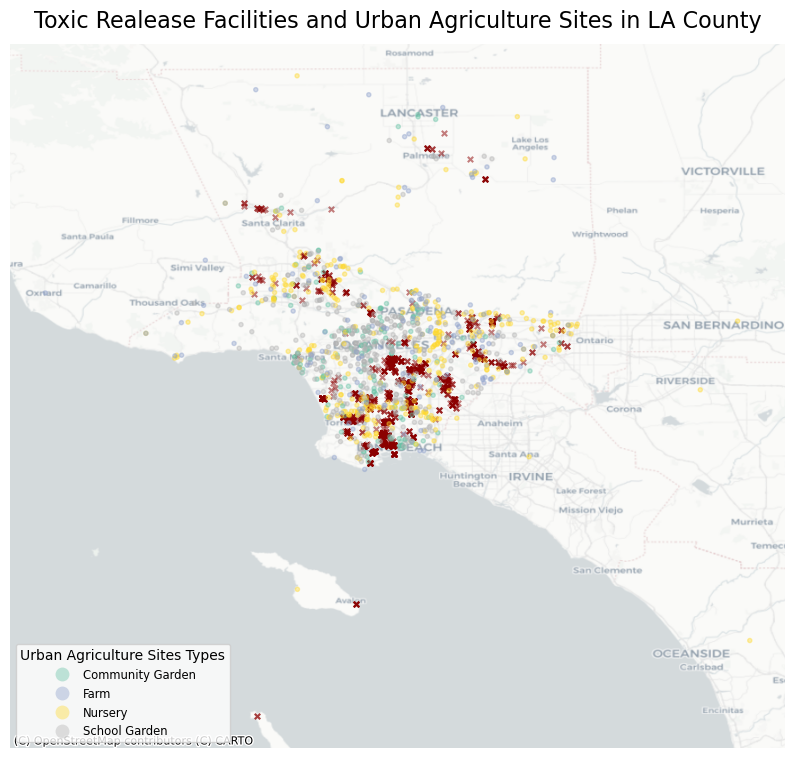

In [111]:
# quick plot
fig, ax = plt.subplots(figsize=(10,10))

# tox release layer
toxrelLACg2.plot(ax=ax,
                marker='x',
                markersize = 15,
                color='darkred',
                alpha=.5,
                legend=False)
# urban ag layer
UALACg2.plot(ax=ax,
                column= 'type_',
                marker='.',
                cmap='Set2',
                alpha=.4,
                legend=True,
                legend_kwds= {'loc':'lower left', 'fontsize':'small'})
# customs
ax.axis('off')
ax.set_title("Toxic Realease Facilities and Urban Agriculture Sites in LA County",fontsize=16, pad=12)
ax.get_legend().set_title('Urban Agriculture Sites Types')

# basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

C:\Users\melod\Programs\envs\uds\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


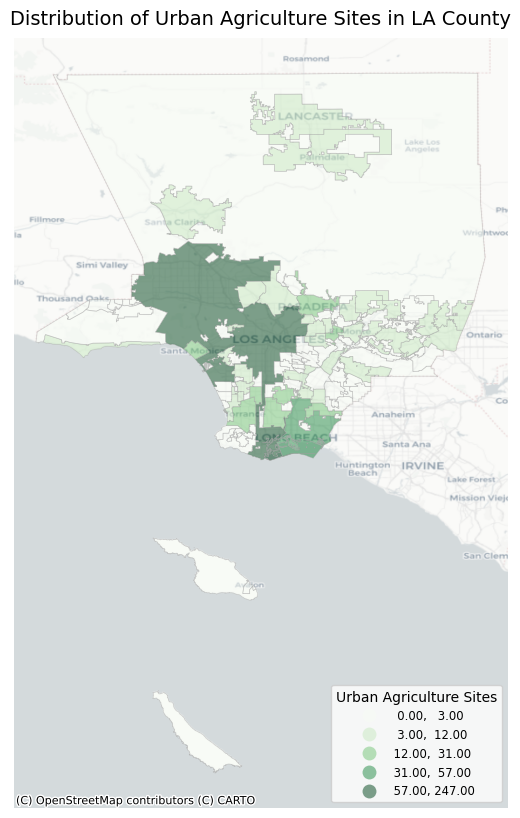

In [92]:
# Urban ag choropleth map
fig, ax = plt.subplots(figsize=(10,10))

# urban ag layer
LACfinal.plot(ax=ax,
                column= 'UA Sites',
                edgecolor = 'darkgrey',
                linewidth =.5,
                cmap='Greens',
                scheme = 'NaturalBreaks',
                alpha=.5,
                legend=True,
                legend_kwds= {'loc':'lower right', 'fontsize':'small'})

# customs
ax.axis('off')
ax.set_title("Distribution of Urban Agriculture Sites in LA County",fontsize=14, pad=10)
ax.get_legend().set_title('Urban Agriculture Sites')

# basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

In [108]:
# creating City column that can be called (since the index column containing the city names cannot be)
LACfinal['City'] = LACfinal.index

In [109]:
# Identifying the city with the highest discharge levels
LACfinal['UA Sites'].max()

247.0

In [110]:
# identifying range of values for discharge to choose the best display settings
LACfinal.loc[LACfinal['UA Sites'] == 247.0, 'City']

City
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Los Angeles    Los Angeles
Name: City, dtype: object

C:\Users\melod\Programs\envs\uds\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


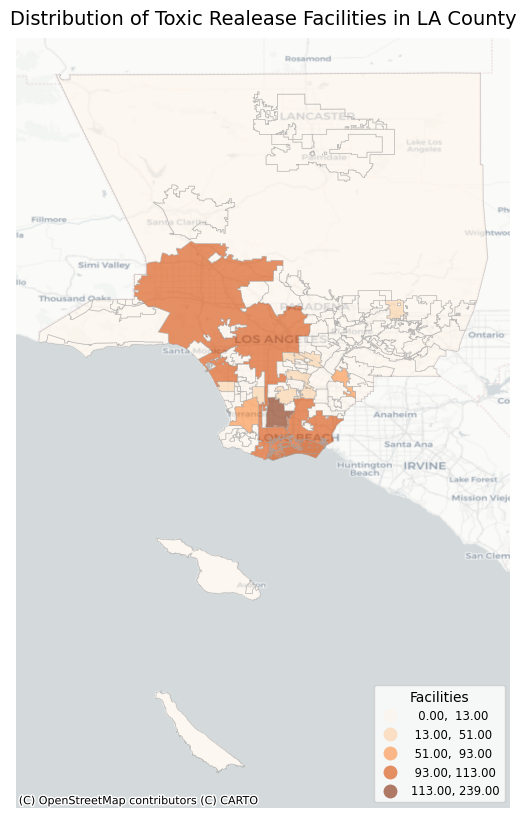

In [91]:
# Toxic release choropleth map
fig, ax = plt.subplots(figsize=(10,10))

# tox release layer
LACfinal.plot(ax=ax,
                column= 'Facilities',
                edgecolor = 'darkgrey',
                linewidth =.5,
                cmap='Oranges',
                scheme = 'NaturalBreaks',
                alpha=.6,
                legend= True,
                legend_kwds= {'loc':'lower right', 'fontsize':'small'})

# customs
ax.axis('off')
ax.set_title("Distribution of Toxic Realease Facilities in LA County",fontsize=14, pad=10)
ax.get_legend().set_title('Facilities')

# basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

In [107]:
# Identifying the city with the highest number of facilities
LACfinal['Facilities'].max()

239.0

In [106]:
# identifying range of values for discharge to choose the best display settings
LACfinal.loc[LACfinal['Facilities'] == 239.0, 'City']

City
Carson    Carson
Name: City, dtype: object

C:\Users\melod\Programs\envs\uds\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


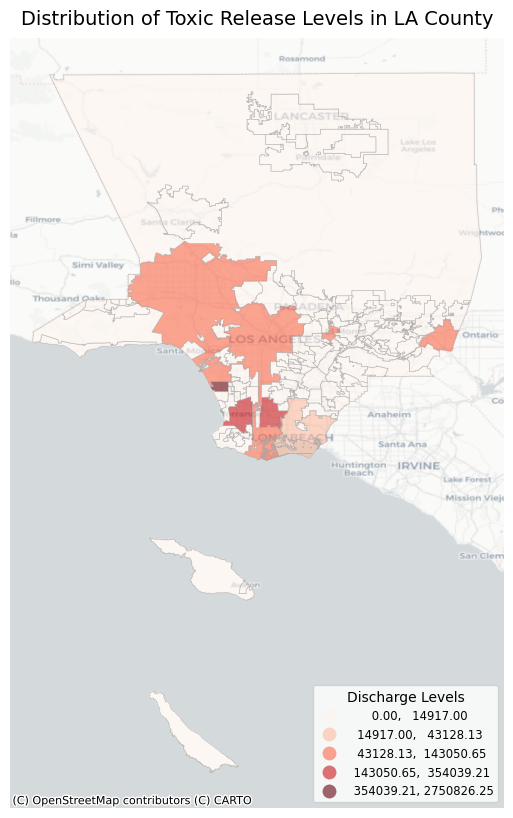

In [52]:
# Toxic release choropleth map
fig, ax = plt.subplots(figsize=(10,10))

# tox release layer
LACfinal.plot(ax=ax,
                column= 'Release Total',
                edgecolor = 'darkgrey',
                linewidth =.5,
                cmap='Reds',
                scheme='NaturalBreaks',
                alpha=.6,
                legend= True,
                legend_kwds= {'loc':'lower right', 'fontsize':'small'})

# customs
ax.axis('off')
ax.set_title("Distribution of Toxic Release Levels in LA County",fontsize=14, pad=10)
ax.get_legend().set_title('Discharge Levels')

# basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

In [103]:
# Identifying the city with the highest discharge levels
LACfinal['Release Total'].max()

2750826.248156

In [102]:
# identifying range of values for discharge to choose the best display settings
LACfinal.loc[LACfinal['Release Total'] == 2750826.248156, 'City']

City
El Segundo    El Segundo
Name: City, dtype: object

In [56]:
# folium map: toggle layers

# base object: frame focus on LA County
LAC = folium.Map(location = [34, -118.3], zoom_start = 8, tiles= 'CartoDB positron', attribution = 'CartoDB')

# adding layer control
folium.LayerControl().add_to(LAC)

# adding toxic release layer
folium.Choropleth(
    geo_data=table,
    data=table,
    key_on='features.properties.City',
    columns=['City', 'Facilities'],
    fill_color='Oranges',
    line_weight=0.1,
    fill_opacity=0.5,
    line_opacity=0.4,
    legend_name= "Density of Toxic Release Facilities").add_to(LAC)

# adding urban ag layer
folium.Choropleth(
    geo_data=table,
    data=table,
    key_on='features.properties.City',
    columns=['City', 'UA Sites'],
    fill_color='Greens',
    line_weight=0.1,
    fill_opacity=0.5,
    line_opacity=0.4,
    legend_name= "Density of Urban Agriculture Sites").add_to(LAC)

AttributeError: 'NoneType' object has no attribute 'get'